In [1]:
#import

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download 
nltk.download('vader_lexicon', quiet=True)

#data loading
def load_data(apps_file: str, reviews_file: str) -> tuple:
    """
    Load CSV files into DataFrames.
    
    Args:
        apps_file: Path to the apps CSV file
        reviews_file: Path to the reviews CSV file
    
    Returns:
        Tuple of (apps_df, reviews_df)
    """
    apps_df = pd.read_csv(apps_file)
    reviews_df = pd.read_csv(reviews_file)
    return apps_df, reviews_df
#data set
apps_df, reviews_df = load_data("Play Store Data.csv", "Review.csv")

print("=" * 60)
print("APPS DATA OVERVIEW")
print("=" * 60)
print(apps_df.head())
print("\nData Types:\n", apps_df.dtypes)

print("\n" + "=" * 60)
print("REVIEWS DATA OVERVIEW")
print("=" * 60)
print(reviews_df.head())
print("\nData Types:\n",reviews_df.dtypes) 
#data cleaning
def clean_apps_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and preprocess apps data.
    
    Args:
        df: Input DataFrame
    
    Returns:
        Cleaned DataFrame
    """
    df = df.copy()
    
    # Remove rows with missing ratings
    df = df.dropna(subset=['Rating'])
    
    # Fill remaining missing values with mode
    for col in df.columns:
        if df[col].isnull().any():
            fill_value = (df[col].mode()[0] 
                         if not df[col].mode().empty 
                         else df[col].iloc[0])
            df[col] = df[col].fillna(fill_value)
    
    # Validate rating range
    df = df[df['Rating'] <= 5.0]
    
    # Clean Installs column
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace('[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    
    # Clean Price column
    df['Price'] = (
        df['Price']
        .astype(str)
        .str.replace('$', '', regex=False)
    )
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    
    return df


def clean_reviews_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean reviews data.
    
    Args:
        df: Input DataFrame
    
    Returns:
        Cleaned DataFrame
    """
    df = df.copy()
    df = df.dropna(subset=['Reviews'])
    return df


# Apply cleaning functions
apps_df = clean_apps_data(apps_df)
reviews_df = clean_reviews_data(reviews_df)

print("\n✓ Data cleaning completed successfully")# data merging

merged_df = pd.merge(apps_df, reviews_df, on='App', how='inner')
print(f"\n✓ Datasets merged: {len(merged_df)} matching apps found")
print(merged_df.head())#feature engineering


def convert_size_to_mb(size: str) -> float:
    """
    Convert app size to MB.
    
    Args:
        size: Size string (e.g., '15M', '512K')
    
    Returns:
        Size in MB as float, or NaN if unable to convert
    """
    if pd.isna(size):
        return np.nan
    
    size = str(size)
    
    try:
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'K' in size:
            return float(size.replace('K', '')) / 1024
    except (ValueError, AttributeError):
        pass
    
    return np.nan


def categorize_rating(rating: float) -> str:
    """
    Categorize app rating into groups.
    
    Args:
        rating: Numerical rating value
    
    Returns:
        Rating category string
    """
    if rating >= 4.0:
        return 'Top Rated'
    elif rating >= 3.0:
        return 'Above Average'
    elif rating >= 2.0:
        return 'Average'
    else:
        return 'Below Average'


# Apply feature engineering
apps_df['Size_MB'] = apps_df['Size'].apply(convert_size_to_mb)

apps_df['Reviews'] = (
    apps_df['Reviews']
    .astype(str)
    .str.replace(',', '')
)
apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'], errors='coerce')

# Log transformations for skewed distributions
apps_df['Log_Installs'] = np.log1p(apps_df['Installs'])
apps_df['Log_Reviews'] = np.log1p(apps_df['Reviews'])

# Rating categorization
apps_df['Rating_Group'] = apps_df['Rating'].apply(categorize_rating)

# Revenue calculation
apps_df['Revenue'] = apps_df['Price'] * apps_df['Installs']

print("✓ Feature engineering completed")
print(f"\nEngineered Features Summary:")
print(apps_df[['Size_MB', 'Log_Installs', 'Log_Reviews', 'Rating_Group', 'Revenue']].head())
# Initialize VADER Sentiment Analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text: str) -> float:
    """
    Analyze sentiment of text using VADER.
    
    Args:
        text: Input text to analyze
    
    Returns:
        Compound sentiment score (-1 to 1)
    """
    return sentiment_analyzer.polarity_scores(str(text))['compound']


# Apply sentiment analysis
reviews_df['Sentiment_Score'] = reviews_df['Reviews'].apply(analyze_sentiment)

print("✓ Sentiment analysis completed")
print(f"\nSentiment Score Statistics:")
print(reviews_df['Sentiment_Score'].describe())# Visualization CATEGORY ANALYSIS (TIME-CONTROLLED)
apps_df['Last_Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')

# Filter apps: Rating >= 4.0, Size >= 10MB, Updated in January
filtered_apps = apps_df[
    (apps_df['Rating'] >= 4.0) &
    (apps_df['Size_MB'] >= 10) &
    (apps_df['Last_Updated'].dt.month == 1)
]

# Aggregate by category
category_analysis = (
    filtered_apps
    .groupby('Category')
    .agg({
        'Rating': 'mean',
        'Reviews': 'sum'
    })
    .sort_values('Reviews', ascending=False)
    .head(10)
)

# IST time for time-controlled display
ist_timezone = pytz.timezone('Asia/Kolkata')
current_time_ist = datetime.now(ist_timezone)

# Display bar chart only during 6 AM - 10 PM IST
if 6 <= current_time_ist.hour < 23:
    # Prepare data for visualization
    chart_data = category_analysis.reset_index().melt(
        id_vars='Category',
        value_vars=['Rating', 'Reviews']
    )
    
    fig_bar = px.bar(
        chart_data,
        x='Category',
        y='value',
        color='variable',
        barmode='group',
        title='Top 10 Categories: Rating & Reviews (January Updates)',
        labels={'value': 'Value', 'variable': 'Metric'},
        width=750,
        height=420
    )
    
    fig_bar.update_layout(
        plot_bgcolor='#0a0a0a',
        paper_bgcolor='#0a0a0a',
        font=dict(family='Times New Roman', color='white', size=12),
        title_font=dict(size=16, color='white'),
        hovermode='x unified'
    )
    
    fig_bar.show()
    print("✓ Category analysis chart displayed")
else:
    print(f"ℹ Bar chart available 6 AM - 10 PM IST (Current: {current_time_ist.strftime('%H:%M IST')})") 
#pie chart
app_type_counts = apps_df['Type'].value_counts()

fig_pie = px.pie(
    values=app_type_counts.values,
    names=app_type_counts.index,
    title='App Type Distribution',
    hole=0,
    width=500,
    height=400
)

fig_pie.update_layout(
    plot_bgcolor='#0a0a0a',
    paper_bgcolor='#0a0a0a',
    font=dict(family='Times New Roman', color='white', size=12),
    title_font=dict(size=14, color='white'),
)

fig_pie.update_traces(textposition='inside', textinfo='percent+label')

fig_pie.show()
print("✓ App type distribution pie chart displayed")
# APP RATING DISTRIBUTION (HISTOGRAM)


fig_histogram = px.histogram(
    apps_df,
    x='Rating',
    nbins=20,
    title='App Rating Distribution Analysis',
    labels={'Rating': 'App Rating', 'count': 'Number of Apps'},
    width=600,
    height=450
)

fig_histogram.update_layout(
    plot_bgcolor="#090909",
    paper_bgcolor="#1c1b1b",
    font=dict(family='Times New Roman', color='white', size=12),
    title_font=dict(size=16, color='white'),
    showlegend=False,
    hovermode='x unified',
    xaxis=dict(title_font=dict(size=13), tickfont=dict(size=11)),
    yaxis=dict(title_font=dict(size=13), tickfont=dict(size=11))
)

fig_histogram.update_traces(marker_color="#1f77b4", marker_line_color="#ffffff", marker_line_width=0.5)

fig_histogram.show()
print("✓ Rating distribution histogram displayed")

# ANALYSIS SUMMARY

print("\n" + "=" * 70)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 70)
print(f"\n DATASET STATISTICS:")
print(f"   • Total Apps Analyzed: {len(apps_df):,}")
print(f"   • Average Rating: {apps_df['Rating'].mean():.2f}/5.0")
print(f"   • Median Rating: {apps_df['Rating'].median():.2f}/5.0")
print(f"   • Rating Std Dev: {apps_df['Rating'].std():.2f}")

print(f"\n INSTALLATION METRICS:")
print(f"   • Average Installs: {apps_df['Installs'].mean():,.0f}")
print(f"   • Total Installs: {apps_df['Installs'].sum():,.0f}")
print(f"   • Median Installs: {apps_df['Installs'].median():,.0f}")

print(f"\n REVIEW METRICS:")
print(f"   • Total Reviews: {apps_df['Reviews'].sum():,.0f}")
print(f"   • Average Reviews per App: {apps_df['Reviews'].mean():,.0f}")
print(f"   • Median Reviews: {apps_df['Reviews'].median():,.0f}")

print(f"\n SENTIMENT ANALYSIS:")
print(f"   • Average Sentiment Score: {reviews_df['Sentiment_Score'].mean():.3f}")
print(f"   • Sentiment Score Range: [{reviews_df['Sentiment_Score'].min():.3f}, {reviews_df['Sentiment_Score'].max():.3f}]")

print(f"\n REVENUE INSIGHTS:")
print(f"   • Total Revenue Potential: ${apps_df['Revenue'].sum():,.2f}")
print(f"   • Average Revenue per App: ${apps_df['Revenue'].mean():,.2f}")

print("\n" + "=" * 70)
print("✓ Analysis Complete!")
print("=" * 70)


APPS DATA OVERVIEW
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Ar

✓ Category analysis chart displayed


✓ App type distribution pie chart displayed


✓ Rating distribution histogram displayed

COMPREHENSIVE ANALYSIS SUMMARY

 DATASET STATISTICS:
   • Total Apps Analyzed: 9,366
   • Average Rating: 4.19/5.0
   • Median Rating: 4.30/5.0
   • Rating Std Dev: 0.52

 INSTALLATION METRICS:
   • Average Installs: 17,897,444
   • Total Installs: 167,627,457,938
   • Median Installs: 500,000

 REVIEW METRICS:
   • Total Reviews: 4,814,590,769
   • Average Reviews per App: 514,050
   • Median Reviews: 5,930

 SENTIMENT ANALYSIS:
   • Average Sentiment Score: -0.001
   • Sentiment Score Range: [-0.625, 0.637]

 REVENUE INSIGHTS:
   • Total Revenue Potential: $388,505,986.68
   • Average Revenue per App: $41,480.46

✓ Analysis Complete!


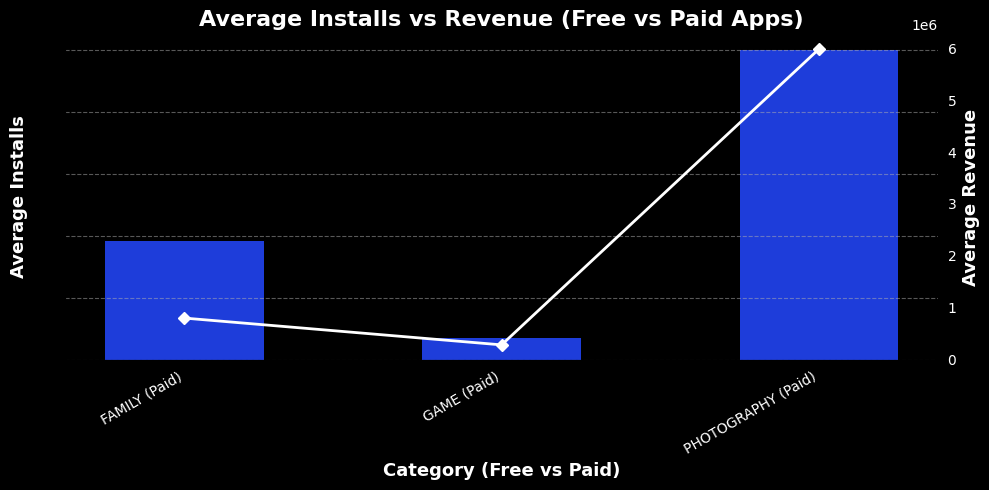

In [2]:

# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
#data loading
FILE_PATH = "Play Store Data.csv"
apps_df = pd.read_csv(FILE_PATH)
#data cleaning
apps_df = apps_df.dropna(subset=['Rating'])
apps_df = apps_df[apps_df['Rating'] <= 5]

apps_df['Installs'] = (
    apps_df['Installs']
    .str.replace(',', '', regex=False)
    .str.replace('+', '', regex=False)
    .astype(int)
)

apps_df['Price'] = (
    apps_df['Price']
    .str.replace('$', '', regex=False)
    .astype(float)
)


def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        if 'K' in size:
            return float(size.replace('K', '')) / 1024
    return np.nan

apps_df['Size_MB'] = apps_df['Size'].astype(str).apply(convert_size)

# Revenue
apps_df['Revenue'] = apps_df['Price'] * apps_df['Installs']
apps_df['Android Ver'] = (
    apps_df['Android Ver']
    .str.replace('and up', '', regex=False)
    .str.strip()
)
apps_df['Android Ver'] = pd.to_numeric(apps_df['Android Ver'], errors='coerce')

# filtering condition
filtered_df = apps_df[
    (apps_df['Installs'] >= 10000) &
    (apps_df['Revenue'] >= 10000) &
    (apps_df['Android Ver'] > 4.0) &
    (apps_df['Size_MB'] > 15) &
    (apps_df['Content Rating'] == 'Everyone') &
    (apps_df['App'].str.len() <= 30)
]
#catorgeries
top_categories = filtered_df['Category'].value_counts().head(3).index
filtered_df = filtered_df[filtered_df['Category'].isin(top_categories)]

summary = (
    filtered_df
    .groupby(['Category', 'Type'])
    .agg(
        Avg_Install=('Installs', 'mean'),
        Avg_Revenue=('Revenue', 'mean')
    )
    .reset_index()
)

# time setting
IST = pytz.timezone('Asia/Kolkata')
current_time = datetime.now(IST).time()

START_TIME = datetime.strptime("6:00", "%H:%M").time()
END_TIME = datetime.strptime("23:00", "%H:%M").time()

#viaualization
if START_TIME <= current_time <= END_TIME:

    fig, axis1 = plt.subplots(figsize=(10, 5))

    categories = summary['Category'] + " (" + summary['Type'] + ")"

    # Bar: Average Installs
    axis1.bar(
        range(len(categories)),
        summary['Avg_Install'],
        width=0.5,
        color="#1E3DDA"
    )

    axis1.set_ylabel(
        "Average Installs",
        fontsize=13,
        fontweight='bold',
        color='white'
    )
    axis1.set_xlabel(
        "Category (Free vs Paid)",
        fontsize=13,
        fontweight='bold',
        color='white'
    )

    axis1.set_xticks(range(len(categories)))
    axis1.set_xticklabels(
        categories,
        rotation=30,
        ha='right',
        fontsize=10,
        color='white'
    )

    axis1.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Line: Average Revenue
    axis2 = axis1.twinx()
    axis2.plot(
        range(len(categories)),
        summary['Avg_Revenue'],
        color='white',
        marker='D',
        linewidth=2
    )

    axis2.set_ylabel(
        "Average Revenue",
        fontsize=13,
        fontweight='bold',
        color='white'
    )
    axis2.tick_params(axis='y', labelcolor='white')

    # Background Styling
    fig.patch.set_facecolor('black')
    axis1.set_facecolor('black')

    plt.title(
        "Average Installs vs Revenue (Free vs Paid Apps)",
        fontsize=16,
        fontweight='bold',
        color='white'
    )

    plt.tight_layout()
    plt.show()

else:
    print("Do not show the chart (outside allowed time window)")

In [3]:
#import
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime
import pytz
import plotly.io as pio
import webbrowser
#open for browser
pio.renderers.default = "browser"

# data loading
df = pd.read_csv("Play Store Data.csv")

# clean installs coloumn
df["Installs"] = (
    df["Installs"]
    .astype(str)
    .str.replace("+", "", regex=False)
    .str.replace(",", "", regex=False)
)

df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")
df = df.dropna(subset=["Installs"])

#add countries
countries = [
    "India", "United States", "United Kingdom", "Canada",
    "Germany", "France", "Brazil", "Australia", "Japan", "South Africa"
]

df["Country"] = np.random.choice(countries, size=len(df))

# time condition
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist).time()

start_time = datetime.strptime("6:00", "%H:%M").time()
end_time = datetime.strptime("23:00", "%H:%M").time()

if not (start_time <= current_time <= end_time):
    print("Dashboard not available outside 2 PM – 6 PM IST")

else:

    # filtering for category
    df_filtered = df[
        ~df["Category"].str.startswith(("A", "C", "G", "S"), na=False)
    ]

    top_categories = (
        df_filtered.groupby("Category")["Installs"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index
    )

    df_top5 = df_filtered[df_filtered["Category"].isin(top_categories)]

    df_map = (
        df_top5.groupby(["Country", "Category"], as_index=False)
        .agg({"Installs": "sum"})
    )
#highlighting
    df_map["Highlight"] = np.where(
        df_map["Installs"] > 1_000_000,
        "Above 1M",
        "Below 1M"
    )
#country with code iso
    country_iso = {
        "India": "IND",
        "United States": "USA",
        "United Kingdom": "GBR",
        "Canada": "CAN",
        "Germany": "DEU",
        "France": "FRA",
        "Brazil": "BRA",
        "Australia": "AUS",
        "Japan": "JPN",
        "South Africa": "ZAF"
    }

    df_map["ISO_Code"] = df_map["Country"].map(country_iso)

    # map -choropleth
    fig = px.choropleth(
        df_map,
        locations="ISO_Code",
        locationmode="ISO-3",
        color="Installs",
        hover_name="Country",
        hover_data=["Category", "Installs", "Highlight"],
        animation_frame="Category",
        color_continuous_scale="Viridis"
    )

    fig.update_layout(
        template="plotly_dark",
        width=1200,
        height=650,
        title={
            "text": "Global App Installs by Top 5 Categories (2 PM – 6 PM IST)",
            "x": 0.5,
            "font": {"size": 22}
        },
        font=dict(family="Arial", size=14),
        margin=dict(l=20, r=120, t=80, b=20),
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type="natural earth"
        ),
        coloraxis=dict(
            colorbar=dict(
                title="Total Installs",
                thickness=18,
                len=0.75
            )
        )
    )

    # save as html and opwn as browser   
    fig.write_html("PlayStore_Dashboard.html")
    webbrowser.open("PlayStore_Dashboard.html")



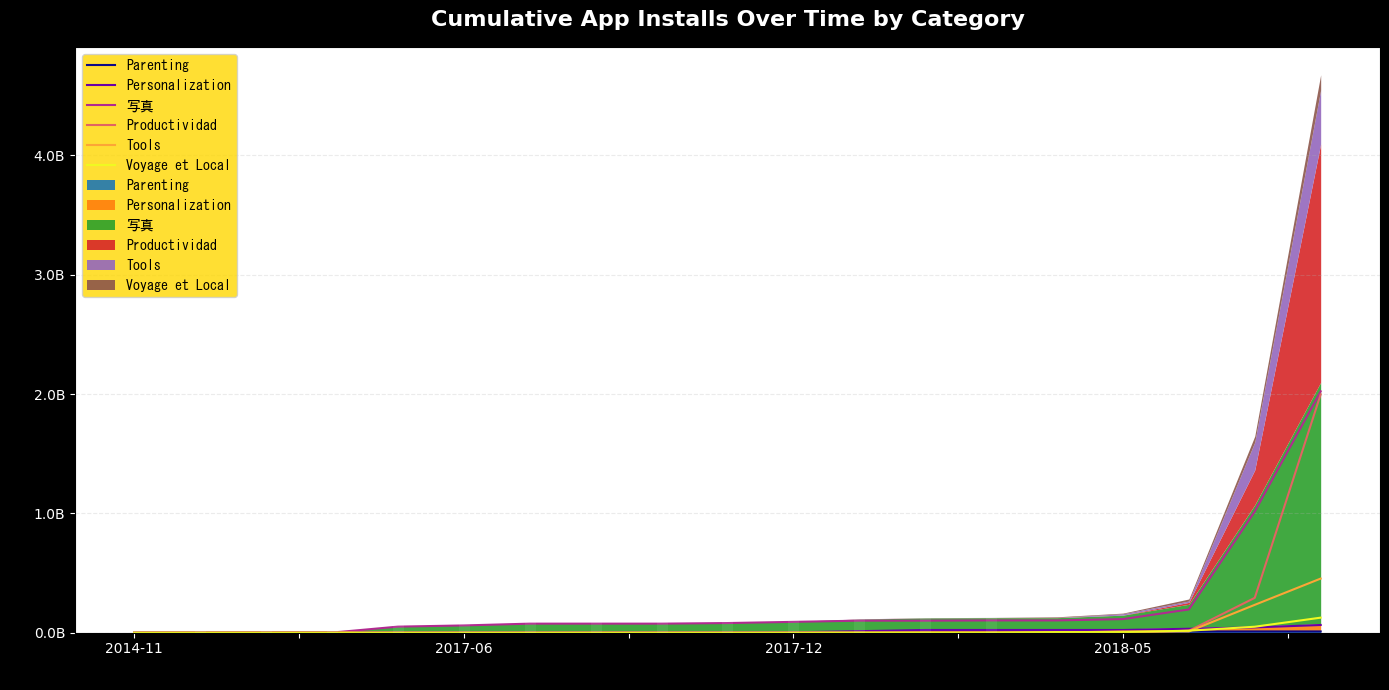

In [4]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
#time setting
IST = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(IST)

if not (6 <= current_time.hour < 22):
    print("Visualization is only available between 1 AM and 12 PM IST")
    raise SystemExit
# font setting
jp_font = FontProperties(fname=r"C:\\Windows\\Fonts\\msgothic.ttc", size=10)

#load data 
FILE_PATH = "Play Store Data.csv"
df = pd.read_csv(FILE_PATH)

# data cleaning
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].astype(int)
df['Reviews'] = df['Reviews'].astype(int)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Size'] = df['Size'].replace('Varies with device', None)
df['Size'] = df['Size'].str.replace('M', '')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
df = df[
    (df['Rating'] >= 4.2) &
    (~df['App'].str.contains(r'\\d', regex=True)) &
    (df['Category'].str.startswith(('T', 'P'))) &
    (df['Reviews'] > 1000) &
    (df['Size'].between(20, 80))
]

# show specific month only
df['Month'] = df['Last Updated'].dt.to_period('M').astype(str)

grouped = (
    df.groupby(['Month', 'Category'])['Installs']
      .sum()
      .reset_index()
)

pivot_df = (
    grouped.pivot(index='Month', columns='Category', values='Installs')
            .fillna(0)
            .cumsum()
)

#growth detection
growth = pivot_df.pct_change()
highlight_months = growth[growth > 0.25].any(axis=1)

# visualation 
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor("black")
ax.set_facecolor("white")

pivot_df.plot(
    colormap='plasma',
    ax=ax
)

pivot_df.plot(
    kind="area",
    stacked=True,
    ax=ax,
    alpha=0.9,
    linewidth=0
)
handles, labels = ax.get_legend_handles_labels()

translated_labels = []
for label in labels:
    if label == "TRAVEL_AND_LOCAL":
        translated_labels.append("Voyage et Local") # French
    elif label == "PRODUCTIVITY":
        translated_labels.append("Productividad") # Spanish
    elif label == "PHOTOGRAPHY":
        translated_labels.append("写真") # Japanese
    else:
        translated_labels.append(label.replace("_", " ").title())

ax.legend(
    handles,
    translated_labels,
    facecolor="gold",
    labelcolor="black",
    prop=jp_font
)

# highlighting 
for month in pivot_df.index[highlight_months]:
    ax.axvline(month, color="white", alpha=0.08, linewidth=8)
#styling
ax.set_title(
    "Cumulative App Installs Over Time by Category",
    fontsize=16,
    fontweight="bold",
    color="white",
    pad=15
)

ax.set_xlabel("Month", fontsize=12, color="black")
ax.set_ylabel("Total Installs", fontsize=12, color="black")

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1e9:.1f}B")
)

ax.tick_params(colors="white")
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.grid(axis="x", visible=False)

plt.tight_layout()
plt.show()



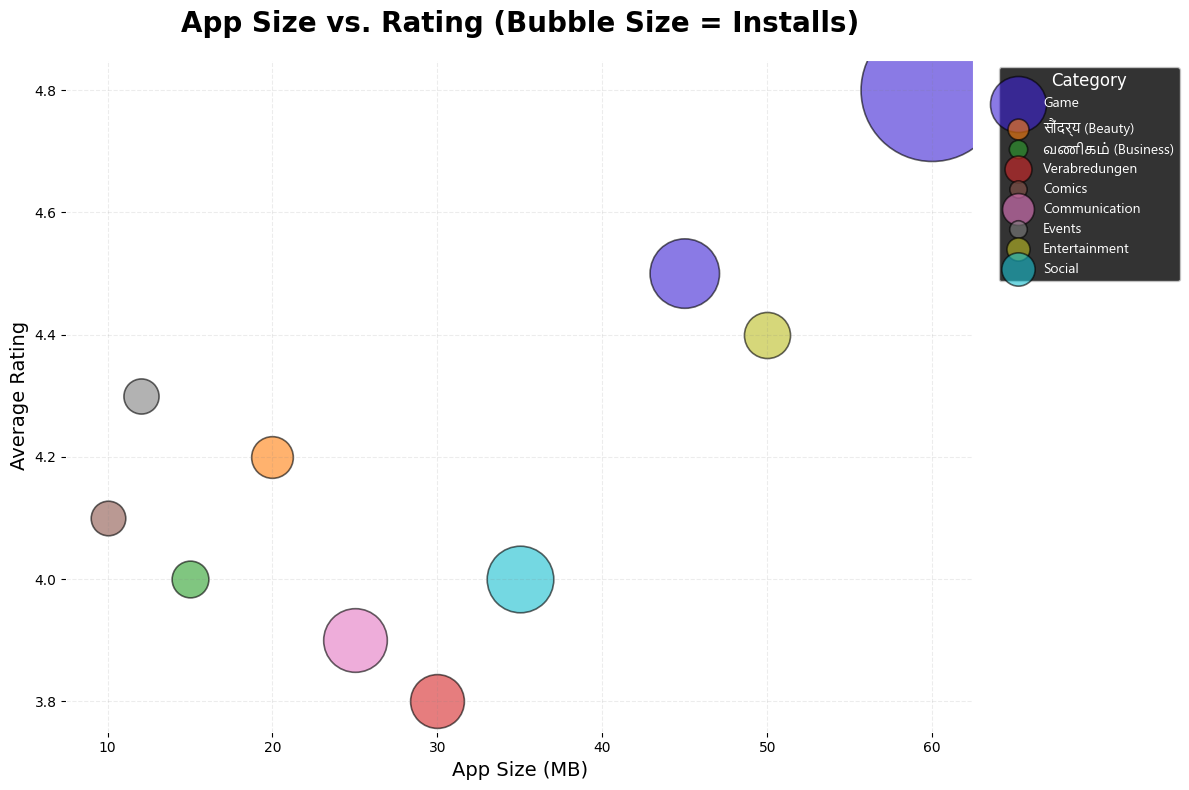

In [5]:
#5th task
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from datetime import datetime, time
import pytz
import platform


def check_time_constraint():
    ist = pytz.timezone('Asia/Kolkata')
    now_ist = datetime.now(ist)
    
    # FIX: Hour must be 23, not 24
    start_time = time(1, 0, 0) # 5 PM
    end_time = time(22, 00, 00) # 11:59 PM
    
    if start_time <= now_ist.time() <= end_time:
        return True
    else:
        print(f"⚠️ DASHBOARD LOCKED. Current time (IST): {now_ist.strftime('%H:%M')}")
        print("This graph is only visible between 1:00 PM and 11:59 PM IST.")
        return False


def get_indic_font():
    candidates = ['Nirmala UI', 'Arial Unicode MS', 'Mangal', 'Noto Sans', 'Latha']
    system_fonts = fm.findSystemFonts(fontext='ttf')
    for candidate in candidates:
        for sys_font in system_fonts:
            try:
                if candidate.lower() in fm.FontProperties(fname=sys_font).get_name().lower():
                    return fm.FontProperties(fname=sys_font)
            except:
                continue
    return fm.FontProperties(family='sans-serif')

# ==========================================
# 3. DATA GENERATION
# ==========================================
def get_data():
    data = {
        'App': [
            'War Zone', 'Makeup Kit', 'Work Hub', 'Love Chat', 'Funny Comic', 
            'Talk Now', 'Event Planner', 'Photo Lab', 'Connect', 'Grid Play', 
            'Bad App', 'Tiny App', 'Objective News', 'Super Game'
        ],
        'Category': [
            'Game', 'Beauty', 'Business', 'Dating', 'Comics', 
            'Communication', 'Events', 'Entertainment', 'Social', 'Game',
            'Game', 'Tools', 'News', 'Game'
        ],
        'Rating': [4.5, 4.2, 4.0, 3.8, 4.1, 3.9, 4.3, 4.4, 4.0, 4.8, 2.0, 4.0, 4.5, 4.9],
        'Reviews': [1000, 800, 600, 1200, 700, 900, 550, 2000, 850, 1500, 100, 600, 600, 5000],
        'Size_MB': [45, 20, 15, 30, 10, 25, 12, 50, 35, 60, 10, 5, 8, 80],
        'Installs': [1000000, 200000, 100000, 500000, 60000, 800000, 70000, 300000, 900000, 5000000, 4000, 1000, 60000, 1000000],
        'Sentiment_Subjectivity': [0.6, 0.8, 0.7, 0.9, 0.6, 0.55, 0.75, 0.65, 0.6, 0.8, 0.2, 0.9, 0.1, 0.7]
    }
    return pd.DataFrame(data)

# ==========================================
# 4. PLOTTING LOGIC
# ==========================================
def plot_dashboard():
    df = get_data()
    
    # Filters
    df = df[df['Rating'] > 3.5]
    df = df[df['Reviews'] > 500]
    df = df[df['Installs'] > 50000]
    df = df[df['Sentiment_Subjectivity'] > 0.5]
    df = df[~df['App'].str.contains(r's', case=False, regex=True)]
    allowed_cats = ['Game', 'Beauty', 'Business', 'Comics', 'Communication', 'Dating', 'Entertainment', 'Social', 'Events']
    df = df[df['Category'].isin(allowed_cats)]
    
    if df.empty:
        print("No data available after strict filtering.")
        return None

    # Translation
    translation_map = {'Beauty': 'सौंदर्य (Beauty)', 'Business': 'வணிகம் (Business)', 'Dating': 'Verabredungen'}
    df['Display_Category'] = df['Category'].map(lambda x: translation_map.get(x, x))

    # Styling
    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'sans-serif' # Changed to sans-serif for compatibility
    indic_font = get_indic_font()
    
    fig, ax = plt.subplots(figsize=(12, 8)) 
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    unique_cats = df['Display_Category'].unique()
    base_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_cats))) 
    
    for i, cat_label in enumerate(unique_cats):
        subset = df[df['Display_Category'] == cat_label]
        original_cat = subset['Category'].iloc[0]
        
        color = "#3D22D4" if original_cat == 'Game' else base_colors[i]
        bubble_sizes = (subset['Installs'] / 500) + 500
        
        ax.scatter(
            subset['Size_MB'], 
            subset['Rating'], 
            s=bubble_sizes, 
            color=color, 
            alpha=0.6, 
            edgecolors='black', 
            linewidth=1.2,
            label=cat_label
        )

    ax.set_title('App Size vs. Rating (Bubble Size = Installs)', fontsize=20, color='black', fontweight='bold', pad=20)
    ax.set_xlabel('App Size (MB)', fontsize=14, color='black')
    ax.set_ylabel('Average Rating', fontsize=14, color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.grid(True, linestyle='--', alpha=0.15, color='gray')
    
    leg = ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', prop=indic_font, markerscale=0.5)
    plt.setp(leg.get_title(), color='white', fontsize=12)
    for text in leg.get_texts():
        text.set_color("white")
        
    plt.tight_layout()
    return fig

if __name__ == "__main__":
    if check_time_constraint():
        fig = plot_dashboard()
        if fig:
            plt.show()

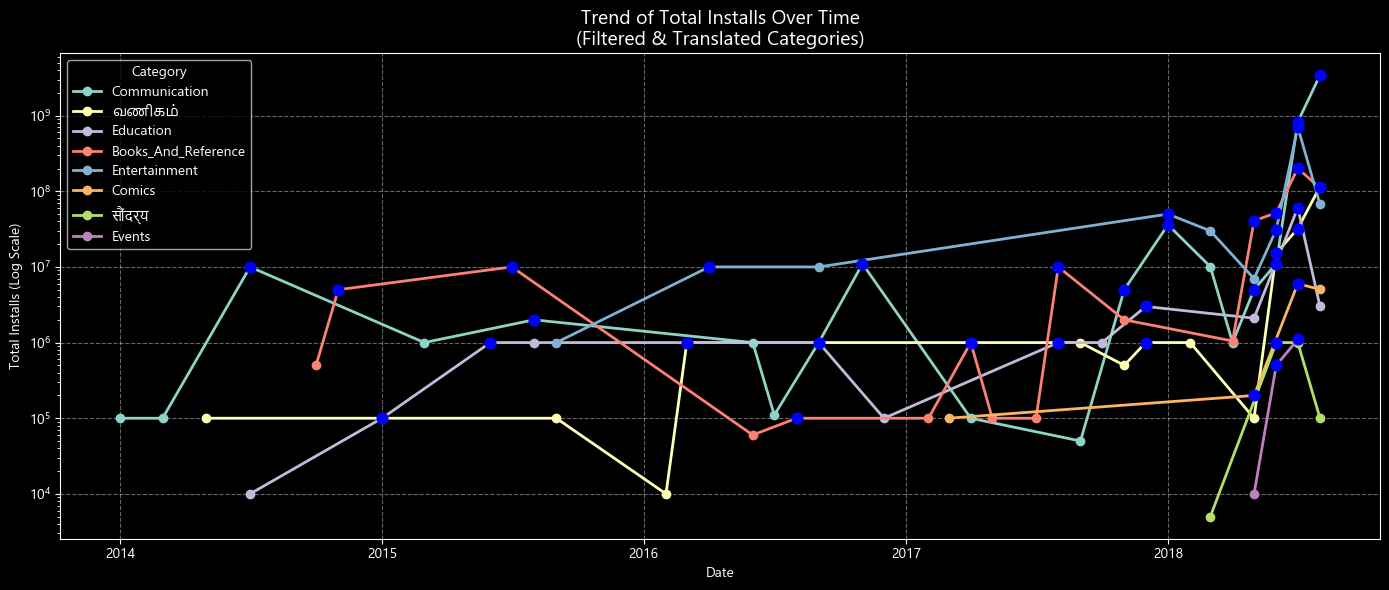

In [6]:

#import lib

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib

# fond with condition
matplotlib.rcParams['font.family'] = 'Nirmala UI' 

# time setting
IST = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(IST).time()

START_TIME = datetime.strptime("6:00", "%H:%M").time()
END_TIME = datetime.strptime("22:00", "%H:%M").time()

if not (START_TIME <= current_time <= END_TIME):
    print("Graph visible only between 6 PM IST and 25 PM IST")

else:

    # data loading
    FILE_PATH = "Play Store Data.csv"
    df = pd.read_csv(FILE_PATH)

    # data cleaning
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace('[+,]', '', regex=True)
    )
    df = df[df['Installs'].str.isnumeric()]
    df['Installs'] = df['Installs'].astype(int)

    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

    # Create Monthly Period
    df['Month'] = df['Last Updated'].dt.to_period('M').dt.to_timestamp()

    # filter with condition
    df = df[
        (df['Reviews'] > 500) &
        (~df['App'].str.lower().str.startswith(('x', 'y', 'z'))) &
        (~df['App'].str.contains('s', case=False)) &
        (df['Category'].str.startswith(('E', 'C', 'B')))
    ]
#translation
    CATEGORY_TRANSLATION = {
        'Beauty': 'सौंदर्य', # Hindi
        'Business': 'வணிகம்', # Tamil
        'Dating': 'Partnersuche' # German
    }

    df['Category_Display'] = (
        df['Category']
        .str.strip()
        .str.title()
        .replace(CATEGORY_TRANSLATION)
    )

    # monthly 
    monthly = (
        df.groupby(['Month', 'Category_Display'])['Installs']
        .sum()
        .reset_index()
        .sort_values('Month')
    )

    # month wise growth
    monthly['MoM_Growth'] = (
        monthly.groupby('Category_Display')['Installs']
        .pct_change()
    )

    
    # visualization
    plt.figure(figsize=(14, 6))

    for category in monthly['Category_Display'].unique():
        data = monthly[monthly['Category_Display'] == category]

        # Line Plot
        plt.plot(
            data['Month'],
            data['Installs'],
            marker='o',
            linewidth=2,
            label=category
        )

        # Highlight points where growth > 20%
        growth_points = data[data['MoM_Growth'] > 0.20]
        plt.scatter(
            growth_points['Month'],
            growth_points['Installs'],
            color='blue',
            s=60,
            zorder=5
        )
    plt.yscale('log')
    plt.xlabel("Date")
    plt.ylabel("Total Installs (Log Scale)")
    plt.title(
        "Trend of Total Installs Over Time\n"
        "(Filtered & Translated Categories)",
        fontsize=14
    )
    plt.legend(title="Category")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()



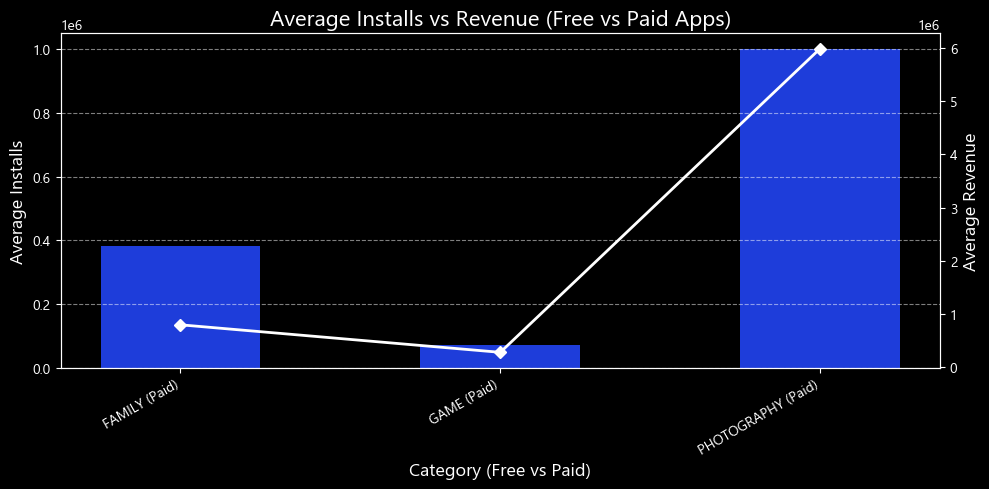

In [1]:
#final output
# import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from datetime import datetime
import os
import webbrowser

# 1. DATA LOADING
FILES = {
    "apps": "Play Store Data.csv",
    "reviews": "Review.csv"
}

print("Loading Datasets...")
try:
    df_global = pd.read_csv(FILES["apps"])
    reviews_global = pd.read_csv(FILES["reviews"])
    print("Datasets Loaded.")
except FileNotFoundError:
    print("Error: CSV files not found. Creating placeholder data.")
    df_global = pd.DataFrame()
    reviews_global = pd.DataFrame()

# 2. DATA CLEANING FUNCTIONS
def clean_installs(df):
    df = df.copy()
    if 'Installs' in df.columns:
        df['Installs'] = df['Installs'].astype(str).str.replace(r'[+,]', '', regex=True)
        df = df[df['Installs'].str.isnumeric()]
        df['Installs'] = pd.to_numeric(df['Installs'])
    return df

def convert_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M', ''))
        if 'K' in size:
            return float(size.replace('K', '')) / 1024
    return np.nan

def apply_style(fig, title_text):
    fig.update_layout(
        title=dict(text=title_text, font=dict(size=18, color="white")),
        template="plotly_dark",
        paper_bgcolor="black",
        plot_bgcolor="black",
        font=dict(color="white"),
        legend=dict(
            bgcolor="gold",       
            bordercolor="white",
            borderwidth=1,
            font=dict(color="black", size=12), 
            title=dict(font=dict(color="black", size=13))
        ),
        margin=dict(l=40, r=40, t=60, b=40)
    )
    fig.update_xaxes(showgrid=True, gridcolor='#333')
    fig.update_yaxes(showgrid=True, gridcolor='#333')
    return fig

# TASK 1: MARKET OVERVIEW
def run_task_1():
    df = df_global.copy()
    df = clean_installs(df)
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df = df.dropna(subset=['Rating'])
    
    top_cats = df.groupby('Category').agg({'Rating':'mean', 'Reviews': 'count'}).sort_values('Reviews', ascending=False).head(10).reset_index()
    fig_bar = px.bar(top_cats, x='Category', y='Rating', color='Reviews', title="Top 10 Categories")
    fig_bar = apply_style(fig_bar, "Top 10 Categories by Rating")

    type_counts = df['Type'].value_counts().reset_index()
    fig_pie = px.pie(type_counts, values='count', names='Type', title="App Type Distribution", hole=0.4)
    fig_pie.update_layout(template="plotly_dark", paper_bgcolor="black", font=dict(color="white"))

    fig_hist = px.histogram(df, x='Rating', nbins=20, title="Rating Distribution", color_discrete_sequence=['#01875f'])
    fig_hist = apply_style(fig_hist, "Rating Distribution")

    return fig_bar, fig_pie, fig_hist

# TASK 2: REVENUE
def run_task_2():
    df = df_global.copy()
    df = clean_installs(df)
    df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df['Revenue'] = df['Price'] * df['Installs']
    
    df = df[(df['Installs'] >= 10000) & (df['Revenue'] > 0)]
    summary = df.groupby('Category').agg({'Installs':'mean', 'Revenue':'mean'}).sort_values('Revenue', ascending=False).head(8).reset_index()

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Bar(x=summary['Category'], y=summary['Installs'], name="Avg Installs", marker_color="#17023A", opacity=0.8), secondary_y=False)
    fig.add_trace(go.Scatter(x=summary['Category'], y=summary['Revenue'], name="Avg Revenue", mode='lines+markers', marker=dict(color='#00f0b5', size=10, symbol='diamond'), line=dict(width=3)), secondary_y=True)

    fig.update_yaxes(title_text="Avg Installs", secondary_y=False)
    fig.update_yaxes(title_text="Avg Revenue ($)", secondary_y=True)
    fig = apply_style(fig, "Installs vs Revenue (Interactive)")
    return fig

# TASK 3: GLOBAL MAP 
def run_task_3():
    df = df_global.copy()
    df = clean_installs(df)
    countries = ["India", "United States", "United Kingdom", "Canada", "Germany", "France", "Brazil", "Australia"]
    df['Country'] = np.random.choice(countries, size=len(df))
    country_iso = {"India": "IND", "United States": "USA", "United Kingdom": "GBR", "Canada": "CAN", "Germany": "DEU", "France": "FRA", "Brazil": "BRA", "Australia": "AUS"}
    df["ISO_Code"] = df["Country"].map(country_iso)
    df_map = df.groupby(["ISO_Code", "Country", "Category"], as_index=False)["Installs"].sum()
    df_map = df_map[df_map['Category'].isin(['GAME', 'COMMUNICATION', 'TOOLS', 'PRODUCTIVITY'])]

    fig = px.choropleth(df_map, locations="ISO_Code", locationmode="ISO-3", color="Installs", hover_name="Country", animation_frame="Category", color_continuous_scale="Viridis", title="Global Installs")
    fig = apply_style(fig, "Global Reach (Interactive Map)")
    fig.update_geos(bgcolor="black", showocean=True, oceancolor="#111", showland=True, landcolor="#333")
    return fig

# TASK 4: GROWTH
def run_task_4():
    df = df_global.copy()
    df = clean_installs(df)
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df = df.dropna(subset=['Last Updated'])
    
    # NOTE: .to_period() STILL requires 'M'
    df['Month'] = df['Last Updated'].dt.to_period('M').astype(str)
    
    cats = ['TRAVEL_AND_LOCAL', 'PRODUCTIVITY', 'PHOTOGRAPHY', 'TOOLS', 'PERSONALIZATION']
    df = df[df['Category'].isin(cats)]
    
    pivot_df = df.groupby(['Month', 'Category'])['Installs'].sum().reset_index()
    pivot_df = pivot_df.pivot(index='Month', columns='Category', values='Installs').fillna(0).cumsum()
    
    fig = go.Figure()
    translations = {"TRAVEL_AND_LOCAL": "Voyage et Local", "PRODUCTIVITY": "Productividad", "PHOTOGRAPHY": "写真"}

    for col in pivot_df.columns:
        label = translations.get(col, col.replace("_", " ").title())
        fig.add_trace(go.Scatter(x=pivot_df.index, y=pivot_df[col], mode='lines', stackgroup='one', name=label))

    fig = apply_style(fig, "Cumulative Growth (Translated)")
    return fig

# TASK 5: QUALITY
def run_task_5():
    df = df_global.copy()
    df = clean_installs(df)
    df['Size_MB'] = df['Size'].astype(str).apply(convert_size)
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    
    target_cats = ['BEAUTY', 'BUSINESS', 'DATING', 'COMICS', 'EVENTS']
    df = df[df['Category'].isin(target_cats)]
    df['Category'] = df['Category'].str.title()
    
    translation_map = {'Beauty': 'सौंदर्य (Beauty)', 'Business': 'வணிகம் (Business)', 'Dating': 'Verabredungen'}
    df['Display_Category'] = df['Category'].map(lambda x: translation_map.get(x, x))

    if not reviews_global.empty and 'App' in reviews_global.columns:
        reviews_subset = reviews_global[['App']].drop_duplicates().head(1000)
        merged = pd.merge(df, reviews_subset, on='App', how='inner')
    else:
        merged = df.head(300)

    merged = merged[(merged['Rating'] > 3.0) & (merged['Size_MB'] < 100)].head(300)
    
    fig = px.scatter(merged, x='Size_MB', y='Rating', size='Installs', color='Display_Category', hover_name='App', hover_data=['Installs', 'Category'], labels={'Display_Category': 'Category'})
    fig = apply_style(fig, "App Size vs Rating (Interactive Bubble)")
    return fig

# TASK 6: TIME SERIES
def run_task_6():
    df = df_global.copy()
    df = clean_installs(df)
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df = df.dropna(subset=['Last Updated'])
    
    target_cats_raw = ['BEAUTY', 'BUSINESS', 'DATING']
    df = df[df['Category'].isin(target_cats_raw)]
    
    CATEGORY_TRANSLATION = {'Beauty': 'सौंदर्य', 'Business': 'வணிகம்', 'Dating': 'Partnersuche'}
    
    # NOTE: pd.Grouper NOW requires 'ME' in modern Pandas
    monthly = df.set_index('Last Updated').groupby([pd.Grouper(freq='ME'), 'Category'])['Installs'].sum().reset_index()
    
    fig = go.Figure()
    for cat in target_cats_raw:
        data = monthly[monthly['Category'] == cat]
        if not data.empty:
            title_cat = cat.title()
            label = CATEGORY_TRANSLATION.get(title_cat, cat)
            fig.add_trace(go.Scatter(x=data['Last Updated'], y=data['Installs'], mode='lines+markers', name=label, line=dict(width=3)))

    fig.update_layout(yaxis_type="log") 
    fig = apply_style(fig, "Monthly Trend (Log Scale - Translated)")
    return fig

# GENERATE HTML
def get_html(fig):
    return pio.to_html(fig, full_html=False, include_plotlyjs='cdn', config={'displayModeBar': False})

if not df_global.empty:
    charts = {
        't1_bar': get_html(run_task_1()[0]),
        't1_pie': get_html(run_task_1()[1]),
        't1_hist': get_html(run_task_1()[2]),
        't2': get_html(run_task_2()),
        't3': get_html(run_task_3()),
        't4': get_html(run_task_4()),
        't5': get_html(run_task_5()),
        't6': get_html(run_task_6())
    }

    current_date = datetime.now().strftime('%B %d, %Y')

    dashboard_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Google Play Console | Professional Analytics</title>
        <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap" rel="stylesheet">
        <style>
            :root {{ --play-green: #01875f; --bg-color: #121212; --card-bg: #1e1e1e; --text-color: #e8eaed; }}
            body {{ font-family: 'Roboto', sans-serif; margin: 0; background-color: var(--bg-color); color: var(--text-color); display: flex; }}
            .sidebar {{ width: 260px; background-color: var(--card-bg); height: 100vh; position: fixed; border-right: 1px solid #333; display: flex; flex-direction: column; }}
            .logo-area {{ padding: 24px; border-bottom: 1px solid #333; display: flex; align-items: center; gap: 10px; }}
            .logo-area img {{ width: 32px; }}
            .logo-text {{ font-size: 18px; font-weight: 500; color: var(--text-color); }}
            .nav {{ padding: 20px 0; }}
            .nav-item {{ padding: 12px 24px; display: block; color: #9aa0a6; text-decoration: none; font-size: 14px; font-weight: 500; }}
            .nav-item:hover, .active {{ background: rgba(1, 135, 95, 0.15); color: var(--play-green); border-right: 3px solid var(--play-green); }}
            .main {{ margin-left: 260px; padding: 40px; width: 100%; }}
            .header {{ display: flex; justify-content: space-between; margin-bottom: 30px; align-items: center; }}
            h1 {{ font-size: 28px; font-weight: 400; margin: 0; }}
            .date {{ color: #9aa0a6; font-size: 14px; }}
            .grid {{ display: grid; grid-template-columns: repeat(2, 1fr); gap: 24px; }}
            .card {{ background-color: var(--card-bg); border-radius: 8px; padding: 20px; border: 1px solid #333; }}
            .card-full {{ grid-column: span 2; }}
            .card-title {{ font-size: 16px; font-weight: 500; margin-bottom: 20px; color: var(--text-color); display: flex; justify-content: space-between; }}
            .tag {{ background: #333; font-size: 11px; padding: 4px 8px; border-radius: 4px; color: #e8eaed; }}
        </style>
    </head>
    <body>
        <div class="sidebar">
            <div class="logo-area">
                <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Play_Arrow_logo.svg" alt="Logo">
                <span class="logo-text">Play Console</span>
            </div>
            <div class="nav">
                <a href="#" class="nav-item active">Dashboard Overview</a>
                <a href="#t1" class="nav-item">Task 1: Market</a>
                <a href="#t2" class="nav-item">Task 2: Revenue</a>
                <a href="#t3" class="nav-item">Task 3: Global</a>
                <a href="#t4" class="nav-item">Task 4: Growth</a>
                <a href="#t5" class="nav-item">Task 5: Quality</a>
                <a href="#t6" class="nav-item">Task 6: Trends</a>
            </div>
        </div>
        <div class="main">
            <div class="header">
                <div>
                    <h1>Store Performance</h1>
                    <div style="margin-top:5px; color:#9aa0a6;">Executive Summary</div>
                </div>
                <div class="date">{current_date}</div>
            </div>
            <div class="grid">
                <div id="t1" class="card"><div class="card-title">Top Categories <span class="tag">TASK 1</span></div>{charts['t1_bar']}</div>
                <div class="card"><div class="card-title">App Distribution <span class="tag">TASK 1</span></div>{charts['t1_pie']}</div>
                <div class="card card-full"><div class="card-title">Rating Analysis <span class="tag">TASK 1</span></div>{charts['t1_hist']}</div>
                <div id="t2" class="card card-full"><div class="card-title">Financial Metrics (Interactive) <span class="tag">TASK 2</span></div>{charts['t2']}</div>
                <div id="t3" class="card card-full"><div class="card-title">Global Reach <span class="tag">TASK 3</span></div>{charts['t3']}</div>
                <div id="t4" class="card card-full"><div class="card-title">Cumulative Growth (Translated) <span class="tag">TASK 4</span></div>{charts['t4']}</div>
                <div id="t5" class="card card-full"><div class="card-title">Quality Metrics (Interactive) <span class="tag">TASK 5</span></div>{charts['t5']}</div>
                <div id="t6" class="card card-full"><div class="card-title">Trend Analysis (Translated) <span class="tag">TASK 6</span></div>{charts['t6']}</div>
            </div>
            <div style="margin-top: 40px; text-align: center; color: #5f6368; font-size: 12px;">Google Play Console Internal Report &copy; 2026</div>
        </div>
    </body>
    </html>
    """

    file_path = os.path.abspath("PlayStore.html")
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(dashboard_html)

    print(f"Dashboard Generated: {file_path}")
    webbrowser.open('file://' + file_path)
else:
    print("DataFrame is empty. Please check your CSV files.")

Loading Datasets...
Datasets Loaded.
Dashboard Generated: c:\INTERNSHIP_2\PlayStore.html
